# X-RAY 이미지로 폐렴 진단

## 목차

 1. 실험환경 Set-up
 2. 데이터 준비하기
 3. 데이터 시각화
 4. CNN 모델링
 5. 데이터 imblanace 처리
 6. 모델 훈련
 7. 결과 확인
 8. Augmentation 기법 적용
 9. 모델 구조 변경후 성능 비교
 10. ResNet-18 구현
 11. 모델 훈련
 12. 결과 확인과 시각화

### 1. 실험환경 Set-up

In [4]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [262]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 준비하기

In [263]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [264]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [265]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [266]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [267]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [268]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [269]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [270]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [271]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [272]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [273]:
# test data set만들고 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [274]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화

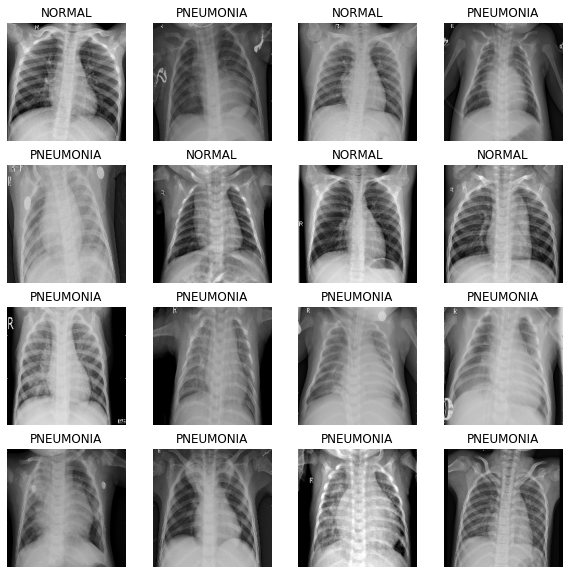

In [252]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. CNN 모델링

In [275]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [276]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [277]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리

In [278]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련

In [279]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 103s 210ms/step - loss: 0.3880 - accuracy: 0.8137 - precision: 0.9519 - recall: 0.7897 - val_loss: 0.7102 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2344 - accuracy: 0.9102 - precision: 0.9740 - recall: 0.9034 - val_loss: 1.0406 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2299 - accuracy: 0.9071 - precision: 0.9693 - recall: 0.9038 - val_loss: 0.4670 - val_accuracy: 0.7779 - val_precision: 0.7671 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1866 - accuracy: 0.9361 - precision: 0.9823 - recall: 0.9308 - val_loss: 0.5554 - val_accuracy: 0.7942 - val_precision: 0.7816 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 56s 214ms/step - loss: 0.1751 - accur

### 7. 결과 확인

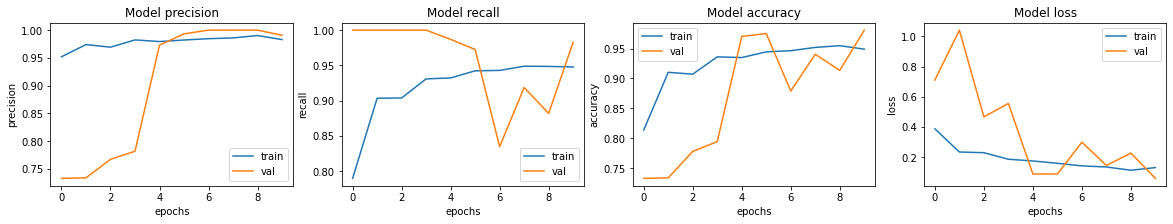

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.7856 - accuracy: 0.7869 - precision: 0.7476 - recall: 0.9949
Loss: 0.7855746746063232,
Accuracy: 0.7868589758872986,
Precision: 0.747591495513916,
Recall: 0.9948717951774597


## 8. Augmentation 기법 적용

In [125]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

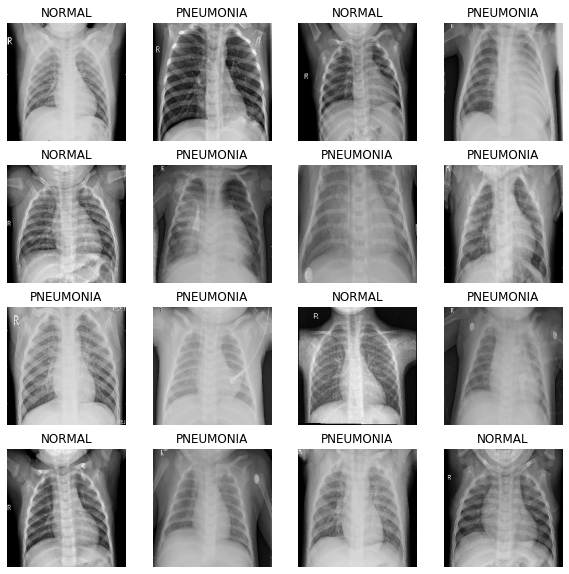

In [127]:
# Augmentation 적용된 데이터 확인
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [143]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [144]:
with tf.device('/GPU:0'):
    history_1 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 62s 201ms/step - loss: 0.3703 - accuracy: 0.8123 - precision: 0.9571 - recall: 0.7828 - val_loss: 0.7457 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2276 - accuracy: 0.9095 - precision: 0.9737 - recall: 0.9030 - val_loss: 1.6246 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.2067 - accuracy: 0.9243 - precision: 0.9722 - recall: 0.9246 - val_loss: 0.2159 - val_accuracy: 0.9029 - val_precision: 0.8831 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1540 - accuracy: 0.9397 - precision: 0.9824 - recall: 0.9357 - val_loss: 0.0991 - val_accuracy: 0.9606 - val_precision: 0.9677 - val_recall: 0.9791
Epoch 5/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1539 - accura

### 베이스 모델과 Augmentation된 모델과의 성능 비교

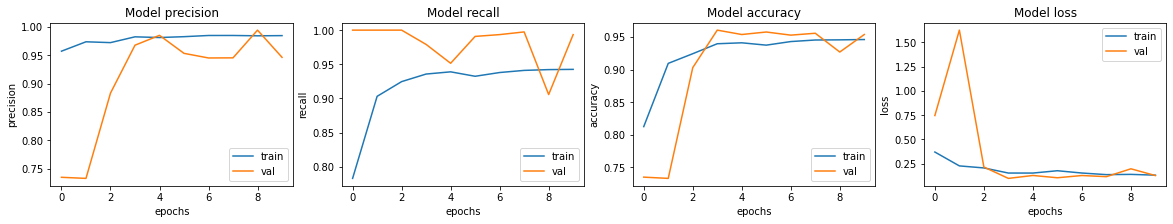

In [145]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_1.history[met])
    ax[i].plot(history_1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [146]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 1.2078 - accuracy: 0.6939 - precision: 0.6713 - recall: 1.0000
Loss: 1.207798957824707,
Accuracy: 0.6939102411270142,
Precision: 0.6712564826011658,
Recall: 1.0


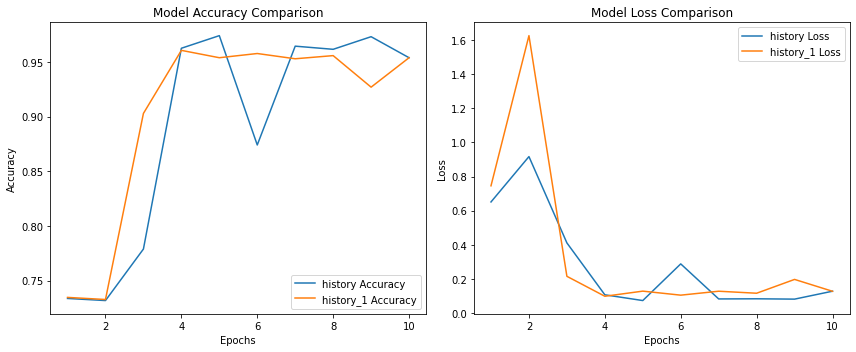

In [157]:
import matplotlib.pyplot as plt

# history과 history2에서 정확도와 손실 값 가져오기
val_accuracy1 = history.history['val_accuracy']
val_accuracy2 = history_1.history['val_accuracy']
val_loss1 = history.history['val_loss']
val_loss2 = history_1.history['val_loss']
epochs = range(1, len(accuracy1) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 플롯
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy1, label='history Accuracy')
plt.plot(epochs, val_accuracy2, label='history_1 Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 플롯
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss1, label='history Loss')
plt.plot(epochs, val_loss2, label='history_1 Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 9. 모델 구조 변경 후 성능 비교

In [280]:
import tensorflow as tf

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model_1 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),  # Filter 수 조정
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),  # Filter 수 조정
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        conv_block(128),
        
        tf.keras.layers.Dropout(0.3),  # Dropout 위치 조정
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),  # Dropout 위치 조정
        
        tf.keras.layers.GlobalAveragePooling2D(),  # Flatten 대신 Global Average Pooling
        
        dense_block(512, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 112, 112, 64) 256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_40[0][0]     
______________________________________________________________________________________________

In [281]:
with tf.device('/GPU:0'):
    model_1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='RMSprop',   # optimizer 변경
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [283]:
with tf.device('/GPU:0'):
    history_2 = model_1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // 20,
        epochs=30,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // 20,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 52s 210ms/step - loss: 0.4304 - accuracy: 0.7865 - precision: 0.9409 - recall: 0.7593 - val_loss: 0.7337 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 44s 211ms/step - loss: 0.2521 - accuracy: 0.9073 - precision: 0.9705 - recall: 0.9040 - val_loss: 0.9487 - val_accuracy: 0.7296 - val_precision: 0.7296 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 45s 215ms/step - loss: 0.2069 - accuracy: 0.9211 - precision: 0.9720 - recall: 0.9204 - val_loss: 1.1287 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 45s 214ms/step - loss: 0.1959 - accuracy: 0.9342 - precision: 0.9763 - recall: 0.9336 - val_loss: 0.1087 - val_accuracy: 0.9579 - val_precision: 0.9635 - val_recall: 0.9806
Epoch 5/30
209/209 [==============================] - 45s 218ms/step - loss: 0.1718 - accura

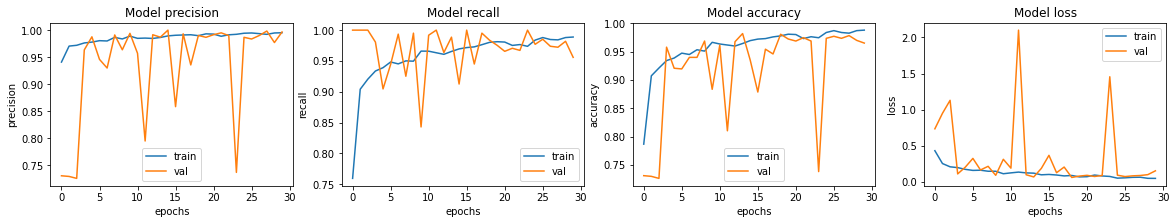

In [284]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

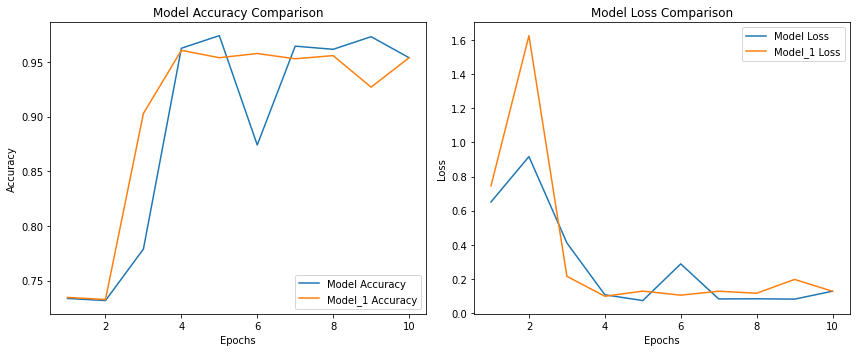

In [285]:
import matplotlib.pyplot as plt

# history과 history2에서 정확도와 손실 값 가져오기
accuracy1 = history.history['val_accuracy']
accuracy2 = history_2.history['val_accuracy']
loss1 = history.history['val_loss']
loss2 = history_2.history['val_loss']
epochs = range(1, len(accuracy1) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 플롯
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy1, label='Model Accuracy')
plt.plot(epochs, val_accuracy2, label='Model_1 Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 플롯
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss1, label='Model Loss')
plt.plot(epochs, val_loss2, label='Model_1 Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 10. ResNet-18 구현

In [288]:
# ResNet-18 모델 구성
def build_resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # conv1
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # conv2_x
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    # conv3_x
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    
    # conv4_x
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    
    # conv5_x
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    
    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected12 (1000 classes)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

modelRes.summary()


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_396 (Conv2D)             (None, 90, 90, 64)   9472        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_472 (BatchN (None, 90, 90, 64)   256         conv2d_396[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_59 (MaxPooling2D) (None, 45, 45, 64)   0           batch_normalization_472[0][0]    
___________________________________________________________________________________________

In [298]:
# 이미지 입력 및 모델 컴파일
input_shape = (180, 180, 3)
num_classes = 1000


modelRes = build_resnet18(input_shape, num_classes)

# Compile the model
modelRes.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.SparseCategoricalAccuracy(name='recall')])

### 11. 모델 훈련

In [299]:
with tf.device('/GPU:0'):
    history_3 = modelRes.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // 20,
        epochs=20,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
209/209 [==============================] - 54s 214ms/step - loss: 0.3966 - accuracy: 0.8771 - recall: 0.8771 - val_loss: 1.0580 - val_accuracy: 0.7596 - val_recall: 0.7596
Epoch 2/20
209/209 [==============================] - 45s 218ms/step - loss: 0.1782 - accuracy: 0.9297 - recall: 0.9297 - val_loss: 0.7832 - val_accuracy: 0.5962 - val_recall: 0.5962
Epoch 3/20
209/209 [==============================] - 45s 218ms/step - loss: 0.1511 - accuracy: 0.9411 - recall: 0.9411 - val_loss: 4.1254 - val_accuracy: 0.7356 - val_recall: 0.7356
Epoch 4/20
209/209 [==============================] - 45s 217ms/step - loss: 0.1521 - accuracy: 0.9411 - recall: 0.9411 - val_loss: 8.5300 - val_accuracy: 0.2654 - val_recall: 0.2654
Epoch 5/20
209/209 [==============================] - 46s 221ms/step - loss: 0.1260 - accuracy: 0.9519 - recall: 0.9519 - val_loss: 0.1056 - val_accuracy: 0.9538 - val_recall: 0.9538
Epoch 6/20
209/209 [==============================] - 46s 219ms/step - loss: 0.0996 -

### 12. 결과 확인과 시각화

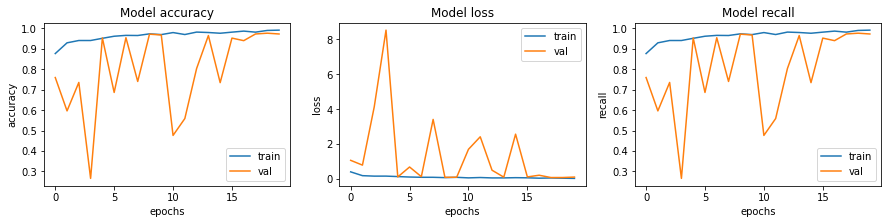

In [300]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'recall']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [302]:
loss, accuracy, recall = modelRes.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy}, \nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 1.0638 - accuracy: 0.8109 - recall: 0.8109
Loss: 1.0638067722320557,
Accuracy: 0.8108974099159241, 
Recall: 0.8108974099159241


## 회고

* CNN 기반의 모델에서는 augmentation 기법을 적용하거나, 모델 구조 변경을 해도 크게 성능차이가 없어 보인다. 더 많은 요소들을 테스트 해봐야 큰 변화를 확인할수 있을것 같다.

* ReNst-18 모델의 경우 높은 성공율을 보이고 있다

* 모델 테스트에 많은 GPU 리소스가 요구되고 생각보다 인내심이 필요하다
* 사소한 코드하나에 에러가 나 바로잡는데 너무 힘들다